In [ ]:
import os, json, random, math
from datetime import datetime
import matplotlib.pyplot as plt
import networkx as nx

ROOT_DIR   = r"./ALL-RNR-ANNOTATED-THREADS"
OUT_PATH   = "pheme_all_events_fast.png"
RANDOM_SEED = 42

# ======================================
MAX_THREADS_TOTAL = 200
MAX_NODES_LAYOUT = 6000
BACKBONE_METHOD = "kcore"
KCORE_K = 2
SPRING_K = 0.9
SPRING_ITERS = 200
# ======================================

def safe_listdir(p):
    try: return [x for x in os.listdir(p) if not x.startswith('.') and not x.startswith('_')]
    except: return []

def load_json(p):
    try:
        with open(p,"r",encoding="utf-8") as f: return json.load(f)
    except: return None

def parse_time_any(ts):
    if not ts: return None
    for fmt in ["%a %b %d %H:%M:%S %z %Y","%Y-%m-%dT%H:%M:%S%z","%Y-%m-%d %H:%M:%S%z","%Y-%m-%dT%H:%M:%S"]:
        try: return datetime.strptime(ts, fmt).timestamp()
        except: pass
    try: return float(ts)
    except: return None

def get_id_str(o):
    for k in ("id_str","id"):
        if k in o: return str(o[k])
    return None
def get_parent_id(o):
    for k in ("in_reply_to_status_id_str","in_reply_to_status_id"):
        if k in o and o[k]: return str(o[k])
    return None
def get_screen_name(o):
    u = o.get("user",{}) if isinstance(o,dict) else {}
    return u.get("screen_name") or u.get("name") or ""

def load_structure_json(thread_dir):
    path = os.path.join(thread_dir, "structure.json")
    if not os.path.isfile(path): return None
    data = load_json(path)
    if not data: return None
    if isinstance(data, dict) and "children" in data:
        adj = {}
        def dfs(node):
            nid = str(node.get("id") or node.get("id_str"))
            adj.setdefault(nid, [])
            for c in node.get("children", []):
                cid = str(c.get("id") or c.get("id_str"))
                adj[nid].append(cid); dfs(c)
        dfs(data); return adj
    elif isinstance(data, dict):
        return {str(k):[str(x) for x in v] for k,v in data.items() if isinstance(v,list)}
    return None

def build_thread_graph(thread_dir):

    st_dir = None
    for cand in ["source-tweets","source-tweet"]:
        p = os.path.join(thread_dir, cand)
        if os.path.isdir(p): st_dir=p; break
    if not st_dir: return None
    srcs = [f for f in safe_listdir(st_dir) if f.endswith(".json")]
    if not srcs: return None
    src = load_json(os.path.join(st_dir, srcs[0])); 
    if not src: return None
    sid = get_id_str(src); 
    if not sid: return None

    rp_dir=None
    for cand in ["reactions","replies"]:
        p=os.path.join(thread_dir,cand)
        if os.path.isdir(p): rp_dir=p; break
    replies=[]
    if rp_dir:
        for f in safe_listdir(rp_dir):
            if f.endswith(".json"):
                obj=load_json(os.path.join(rp_dir,f))
                if obj: replies.append(obj)

    G=nx.DiGraph()
    G.add_node(sid, user=get_screen_name(src), t=parse_time_any(src.get("created_at","")), is_source=True)
    for r in replies:
        rid=get_id_str(r)
        if rid: G.add_node(rid, user=get_screen_name(r), t=parse_time_any(r.get("created_at","")), is_source=False)

    adj = load_structure_json(thread_dir)
    if adj:
        for p, chs in adj.items():
            for c in chs:
                if p == c:
                    continue
                if p in G and c in G:
                    G.add_edge(p, c)
    else:
        for r in replies:
            rid = get_id_str(r)
            if not rid:
                continue
            par = get_parent_id(r)
            if par and par in G and par != rid:
                G.add_edge(par, rid)
            else:
                if rid != sid:
                    G.add_edge(sid, rid)

    return G

def collect_all_threads(root_dir, max_threads):
    random.seed(RANDOM_SEED)
    event_dirs=[os.path.join(root_dir,d) for d in safe_listdir(root_dir) if os.path.isdir(os.path.join(root_dir,d))]
    thread_dirs=[]
    for ev in event_dirs:
        for cat in ["rumours","non-rumours"]:
            cd=os.path.join(ev,cat)
            if not os.path.isdir(cd): continue
            for th in safe_listdir(cd):
                td=os.path.join(cd,th)
                if os.path.isdir(td): thread_dirs.append(td)
    random.shuffle(thread_dirs)
    return thread_dirs[:max_threads]

def merge_graphs(graphs):
    H=nx.Graph()
    for G in graphs:
        H.add_nodes_from(G.nodes(data=True))
        for u,v in G.edges(): H.add_edge(u,v)
    return H

def backbone_graph(H):
    U = H.copy()
    if BACKBONE_METHOD == "kcore":
        k = KCORE_K
        while k>=1:
            core = nx.k_core(U, k=k)
            if core.number_of_nodes()>0: return core
            k -= 1
        return U
    else:
        UW = U.copy()
        for u,v in UW.edges():
            UW[u][v]["w"] = (U.degree(u)+U.degree(v))/2.0
        T = nx.maximum_spanning_tree(UW, weight="w")
        return T

def place_leaves_radially(H, pos_backbone):

    pos = dict(pos_backbone)
    backbone_nodes = set(pos_backbone.keys())
    leaves = [n for n in H.nodes() if n not in backbone_nodes]

    children_of = {}
    for u,v in H.edges():
        if u in backbone_nodes and v not in backbone_nodes:
            children_of.setdefault(u,[]).append(v)
        if v in backbone_nodes and u not in backbone_nodes:
            children_of.setdefault(v,[]).append(u)
    for p, chs in children_of.items():
        cx, cy = pos[p]
        r = 0.06 * math.log(len(chs)+2)
        for i, c in enumerate(chs):
            ang = 2*math.pi * i / len(chs)
            pos[c] = (cx + r*math.cos(ang), cy + r*math.sin(ang))
    rnd = random.Random(RANDOM_SEED)
    for n in leaves:
        if n not in pos:
            anchor = rnd.choice(list(pos_backbone.keys()))
            ax, ay = pos[anchor]
            pos[n] = (ax + rnd.uniform(-0.05,0.05), ay + rnd.uniform(-0.05,0.05))
    return pos

def main():

    threads = collect_all_threads(ROOT_DIR, MAX_THREADS_TOTAL)
    graphs=[]
    for td in threads:
        G = build_thread_graph(td)
        if G and G.number_of_nodes()>1:
            graphs.append(G)
    if not graphs:
        raise RuntimeError("No valid threads loaded.")

    H = merge_graphs(graphs)

    if H.number_of_nodes() > MAX_NODES_LAYOUT:
        nodes_sorted = sorted(H.nodes(), key=lambda n: H.degree(n), reverse=True)[:MAX_NODES_LAYOUT]
        H_sub = H.subgraph(nodes_sorted).copy()
    else:
        H_sub = H

    B = backbone_graph(H_sub)
    pos_backbone = nx.spring_layout(B, k=SPRING_K, iterations=SPRING_ITERS, seed=RANDOM_SEED)

    pos = place_leaves_radially(H, pos_backbone)

    sizes = [120 + 60 * H.degree(n) for n in H.nodes()]
    fig, ax = plt.subplots(figsize=(12, 9))
    nx.draw_networkx_edges(H, pos, ax=ax, alpha=0.12, width=0.6)
    nx.draw_networkx_nodes(H, pos, ax=ax, node_size=sizes)
    ax.set_title("PHEME: All Events (fast backbone + radial leaves)", fontsize=14)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(OUT_PATH, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"[OK] Saved -> {OUT_PATH}")

if __name__ == "__main__":
    main()


[OK] Saved -> pheme_all_events_fast.png


In [ ]:
import os, json, random, math
from datetime import datetime
import matplotlib.pyplot as plt
import networkx as nx

# ==========================
ROOT_DIR = r"./ALL-RNR-ANNOTATED-THREADS"
RANDOM_SEED = 42

MAX_THREADS_PER_EVENT = 40
MAX_NODES_LAYOUT = 4000
KCORE_K = 2
SPRING_K = 0.9
SPRING_ITERS = 200
# ==========================

def safe_listdir(p):
    try: return [x for x in os.listdir(p) if not x.startswith('.') and not x.startswith('_')]
    except: return []

def load_json(p):
    try:
        with open(p,"r",encoding="utf-8") as f: return json.load(f)
    except: return None

def parse_time_any(ts):
    if not ts: return None
    for fmt in ["%a %b %d %H:%M:%S %z %Y","%Y-%m-%dT%H:%M:%S%z","%Y-%m-%d %H:%M:%S%z","%Y-%m-%dT%H:%M:%S"]:
        try: return datetime.strptime(ts, fmt).timestamp()
        except: pass
    try: return float(ts)
    except: return None

def get_id_str(o):
    for k in ("id_str","id"):
        if k in o: return str(o[k])
    return None

def get_parent_id(o):
    for k in ("in_reply_to_status_id_str","in_reply_to_status_id"):
        if k in o and o[k]: return str(o[k])
    return None

def get_screen_name(o):
    u = o.get("user",{}) if isinstance(o,dict) else {}
    return u.get("screen_name") or u.get("name") or ""

def load_structure_json(thread_dir):
    path = os.path.join(thread_dir, "structure.json")
    if not os.path.isfile(path): return None
    data = load_json(path)
    if not data: return None
    if isinstance(data, dict) and "children" in data:
        adj = {}
        def dfs(node):
            nid = str(node.get("id") or node.get("id_str"))
            adj.setdefault(nid, [])
            for c in node.get("children", []):
                cid = str(c.get("id") or c.get("id_str"))
                adj[nid].append(cid); dfs(c)
        dfs(data); return adj
    elif isinstance(data, dict):
        return {str(k): [str(x) for x in v] for k, v in data.items() if isinstance(v, list)}
    return None

def build_thread_graph(thread_dir):
    st_dir = None
    for cand in ["source-tweets","source-tweet"]:
        p = os.path.join(thread_dir, cand)
        if os.path.isdir(p): st_dir = p; break
    if not st_dir: return None
    srcs = [f for f in safe_listdir(st_dir) if f.endswith(".json")]
    if not srcs: return None
    src = load_json(os.path.join(st_dir, srcs[0]))
    if not src: return None
    sid = get_id_str(src)
    if not sid: return None

    rp_dir = None
    for cand in ["reactions","replies"]:
        p = os.path.join(thread_dir, cand)
        if os.path.isdir(p): rp_dir = p; break
    replies = []
    if rp_dir:
        for f in safe_listdir(rp_dir):
            if f.endswith(".json"):
                obj = load_json(os.path.join(rp_dir, f))
                if obj: replies.append(obj)

    G = nx.DiGraph()
    G.add_node(sid, user=get_screen_name(src), t=parse_time_any(src.get("created_at","")), is_source=True)
    for r in replies:
        rid = get_id_str(r)
        if rid:
            G.add_node(rid, user=get_screen_name(r), t=parse_time_any(r.get("created_at","")), is_source=False)

    adj = load_structure_json(thread_dir)
    if adj:
        for p, chs in adj.items():
            for c in chs:
                if p == c:
                    continue
                if p in G and c in G:
                    G.add_edge(p, c)
    else:
        for r in replies:
            rid = get_id_str(r)
            if not rid:
                continue
            par = get_parent_id(r)
            if par and par in G and par != rid:
                G.add_edge(par, rid)
            else:
                if rid != sid:
                    G.add_edge(sid, rid)

    return G

def merge_graphs(graphs):
    H = nx.Graph()
    for G in graphs:
        H.add_nodes_from(G.nodes(data=True))
        H.add_edges_from(G.edges())
    return H

def backbone_kcore(H, k=2):
    U = H.copy()
    while k >= 1:
        core = nx.k_core(U, k=k)
        if core.number_of_nodes() > 0: return core
        k -= 1
    return U

def place_leaves_radially(H, pos_backbone, seed=42):
    pos = dict(pos_backbone)
    backbone_nodes = set(pos_backbone.keys())
    leaves = [n for n in H.nodes() if n not in backbone_nodes]

    children_of = {}
    for u, v in H.edges():
        if u in backbone_nodes and v not in backbone_nodes:
            children_of.setdefault(u, []).append(v)
        if v in backbone_nodes and u not in backbone_nodes:
            children_of.setdefault(v, []).append(u)

    for p, chs in children_of.items():
        cx, cy = pos[p]
        r = 0.06 * math.log(len(chs) + 2)
        for i, c in enumerate(chs):
            ang = 2 * math.pi * i / len(chs)
            pos[c] = (cx + r * math.cos(ang), cy + r * math.sin(ang))

    rnd = random.Random(seed)
    for n in leaves:
        if n not in pos:
            anchor = rnd.choice(list(pos_backbone.keys()))
            ax, ay = pos[anchor]
            pos[n] = (ax + rnd.uniform(-0.05, 0.05), ay + rnd.uniform(-0.05, 0.05))
    return pos

def draw_one_event(ev_dir):
    ev_name = os.path.basename(ev_dir)
    thread_dirs = []
    for cat in ["rumours","non-rumours"]:
        cd = os.path.join(ev_dir, cat)
        if not os.path.isdir(cd): continue
        for th in safe_listdir(cd):
            td = os.path.join(cd, th)
            if os.path.isdir(td): thread_dirs.append(td)
    random.shuffle(thread_dirs)
    thread_dirs = thread_dirs[:MAX_THREADS_PER_EVENT]

    graphs = []
    for td in thread_dirs:
        G = build_thread_graph(td)
        if G and G.number_of_nodes() > 1:
            graphs.append(G)
    if not graphs:
        print(f"[WARN] {ev_name}: no valid threads, skip.")
        return

    H = merge_graphs(graphs)

    if H.number_of_nodes() > MAX_NODES_LAYOUT:
        nodes_sorted = sorted(H.nodes(), key=lambda n: H.degree(n), reverse=True)[:MAX_NODES_LAYOUT]
        H_sub = H.subgraph(nodes_sorted).copy()
    else:
        H_sub = H

    B = backbone_kcore(H_sub, k=KCORE_K)
    pos_backbone = nx.spring_layout(B, k=SPRING_K, iterations=SPRING_ITERS, seed=RANDOM_SEED)
    pos = place_leaves_radially(H, pos_backbone, seed=RANDOM_SEED)

    sizes = [120 + 60 * H.degree(n) for n in H.nodes()]
    fig, ax = plt.subplots(figsize=(12, 9))
    nx.draw_networkx_edges(H, pos, ax=ax, alpha=0.12, width=0.6)
    nx.draw_networkx_nodes(H, pos, ax=ax, node_size=sizes)
    ax.set_title(f"PHEME: {ev_name} (k-core backbone + radial leaves)", fontsize=13)
    ax.axis("off")
    plt.tight_layout()
    out_path = f"pheme_{ev_name}.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"[OK] {ev_name} -> {out_path}")

def main():
    random.seed(RANDOM_SEED)
    events = [os.path.join(ROOT_DIR, d) for d in safe_listdir(ROOT_DIR) if os.path.isdir(os.path.join(ROOT_DIR, d))]
    for ev in events:
        draw_one_event(ev)

if __name__ == "__main__":
    main()


[OK] charliehebdo-all-rnr-threads -> pheme_charliehebdo-all-rnr-threads.png
[OK] ebola-essien-all-rnr-threads -> pheme_ebola-essien-all-rnr-threads.png
[OK] ferguson-all-rnr-threads -> pheme_ferguson-all-rnr-threads.png
[OK] germanwings-crash-all-rnr-threads -> pheme_germanwings-crash-all-rnr-threads.png
[OK] gurlitt-all-rnr-threads -> pheme_gurlitt-all-rnr-threads.png
[OK] ottawashooting-all-rnr-threads -> pheme_ottawashooting-all-rnr-threads.png
[OK] prince-toronto-all-rnr-threads -> pheme_prince-toronto-all-rnr-threads.png
[OK] putinmissing-all-rnr-threads -> pheme_putinmissing-all-rnr-threads.png
[OK] sydneysiege-all-rnr-threads -> pheme_sydneysiege-all-rnr-threads.png


In [ ]:
import os, json, random, math
from datetime import datetime
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# =============================
ROOT_DIR = r"./ALL-RNR-ANNOTATED-THREADS"
RANDOM_SEED = 42

MAX_THREADS_PER_EVENT = 40
MAX_NODES_LAYOUT = 4000
KCORE_K = 2
SPRING_K = 0.9
SPRING_ITERS = 200
# =============================

# ================================
COLOR_MODE = "kcore"
TOP_LABELS = 30
OUTLINE_ORIGINS = True
# ================================

def safe_listdir(p):
    try: return [x for x in os.listdir(p) if not x.startswith('.') and not x.startswith('_')]
    except: return []

def load_json(p):
    try:
        with open(p,"r",encoding="utf-8") as f: return json.load(f)
    except: return None

def parse_time_any(ts):
    if not ts: return None
    for fmt in ["%a %b %d %H:%M:%S %z %Y","%Y-%m-%dT%H:%M:%S%z","%Y-%m-%d %H:%M:%S%z","%Y-%m-%dT%H:%M:%S"]:
        try: return datetime.strptime(ts, fmt).timestamp()
        except: pass
    try: return float(ts)
    except: return None

def get_id_str(o):
    for k in ("id_str","id"):
        if k in o: return str(o[k])
    return None

def get_parent_id(o):
    for k in ("in_reply_to_status_id_str","in_reply_to_status_id"):
        if k in o and o[k]: return str(o[k])
    return None

def get_screen_name(o):
    u = o.get("user",{}) if isinstance(o,dict) else {}
    return u.get("screen_name") or u.get("name") or ""

def load_structure_json(thread_dir):
    path = os.path.join(thread_dir, "structure.json")
    if not os.path.isfile(path): return None
    data = load_json(path)
    if not data: return None
    if isinstance(data, dict) and "children" in data:
        adj = {}
        def dfs(node):
            nid = str(node.get("id") or node.get("id_str"))
            adj.setdefault(nid, [])
            for c in node.get("children", []):
                cid = str(c.get("id") or c.get("id_str"))
                adj[nid].append(cid); dfs(c)
        dfs(data); return adj
    elif isinstance(data, dict):
        return {str(k): [str(x) for x in v] for k, v in data.items() if isinstance(v, list)}
    return None

def build_thread_graph(thread_dir):
    st_dir = None
    for cand in ["source-tweets","source-tweet"]:
        p = os.path.join(thread_dir, cand)
        if os.path.isdir(p): st_dir = p; break
    if not st_dir: return None
    srcs = [f for f in safe_listdir(st_dir) if f.endswith(".json")]
    if not srcs: return None
    src = load_json(os.path.join(st_dir, srcs[0]))
    if not src: return None
    sid = get_id_str(src)
    if not sid: return None

    rp_dir = None
    for cand in ["reactions","replies"]:
        p = os.path.join(thread_dir, cand)
        if os.path.isdir(p): rp_dir = p; break
    replies = []
    if rp_dir:
        for f in safe_listdir(rp_dir):
            if f.endswith(".json"):
                obj = load_json(os.path.join(rp_dir, f))
                if obj: replies.append(obj)

    G = nx.DiGraph()
    G.add_node(sid, user=get_screen_name(src), t=parse_time_any(src.get("created_at","")), is_source=True)
    for r in replies:
        rid = get_id_str(r)
        if rid:
            G.add_node(rid, user=get_screen_name(r), t=parse_time_any(r.get("created_at","")), is_source=False)

    adj = load_structure_json(thread_dir)
    if adj:
        for p, chs in adj.items():
            for c in chs:
                if p == c:
                    continue
                if p in G and c in G:
                    G.add_edge(p, c)
    else:
        for r in replies:
            rid = get_id_str(r)
            if not rid: continue
            par = get_parent_id(r)
            if par and par in G and par != rid:
                G.add_edge(par, rid)
            else:
                if rid != sid:
                    G.add_edge(sid, rid)

    return G

def merge_graphs(graphs):
    H = nx.Graph()
    for G in graphs:
        H.add_nodes_from(G.nodes(data=True))
        H.add_edges_from(G.edges())
    return H

def backbone_kcore(H, k=2):
    U = H.copy()
    U.remove_edges_from(nx.selfloop_edges(U))
    while k >= 1:
        core = nx.k_core(U, k=k)
        if core.number_of_nodes() > 0: return core
        k -= 1
    return U

def place_leaves_radially(H, pos_backbone, seed=42):
    pos = dict(pos_backbone)
    backbone_nodes = set(pos_backbone.keys())
    leaves = [n for n in H.nodes() if n not in backbone_nodes]

    children_of = {}
    for u, v in H.edges():
        if u in backbone_nodes and v not in backbone_nodes:
            children_of.setdefault(u, []).append(v)
        if v in backbone_nodes and u not in backbone_nodes:
            children_of.setdefault(v, []).append(u)

    for p, chs in children_of.items():
        cx, cy = pos[p]
        r = 0.06 * math.log(len(chs) + 2)
        for i, c in enumerate(chs):
            ang = 2 * math.pi * i / len(chs)
            pos[c] = (cx + r * math.cos(ang), cy + r * math.sin(ang))

    rnd = random.Random(seed)
    for n in leaves:
        if n not in pos:
            anchor = rnd.choice(list(pos_backbone.keys()))
            ax, ay = pos[anchor]
            pos[n] = (ax + rnd.uniform(-0.05, 0.05), ay + rnd.uniform(-0.05, 0.05))
    return pos

def draw_one_event(ev_dir):
    ev_name = os.path.basename(ev_dir)
    thread_dirs = []
    for cat in ["rumours","non-rumours"]:
        cd = os.path.join(ev_dir, cat)
        if not os.path.isdir(cd): continue
        for th in safe_listdir(cd):
            td = os.path.join(cd, th)
            if os.path.isdir(td): thread_dirs.append(td)
    random.shuffle(thread_dirs)
    thread_dirs = thread_dirs[:MAX_THREADS_PER_EVENT]

    graphs = []
    for td in thread_dirs:
        G = build_thread_graph(td)
        if G and G.number_of_nodes() > 1:
            graphs.append(G)
    if not graphs:
        print(f"[WARN] {ev_name}: no valid threads, skip.")
        return

    H = merge_graphs(graphs)
    H.remove_edges_from(nx.selfloop_edges(H))

    if H.number_of_nodes() > MAX_NODES_LAYOUT:
        nodes_sorted = sorted(H.nodes(), key=lambda n: H.degree(n), reverse=True)[:MAX_NODES_LAYOUT]
        H_sub = H.subgraph(nodes_sorted).copy()
    else:
        H_sub = H

    B = backbone_kcore(H_sub, k=KCORE_K)
    pos_backbone = nx.spring_layout(B, k=SPRING_K, iterations=SPRING_ITERS, seed=RANDOM_SEED)
    pos = place_leaves_radially(H, pos_backbone, seed=RANDOM_SEED)

    sizes = [120 + 60 * H.degree(n) for n in H.nodes()]
    node_list = list(H.nodes())
    deg_vals  = [H.degree(n) for n in node_list]

    fig, ax = plt.subplots(figsize=(12, 9))

    nx.draw_networkx_edges(H, pos, ax=ax, alpha=0.12, width=0.6)

    legend_handles = []
    if COLOR_MODE == "kcore":
        core_num = nx.core_number(H)
        vals = [core_num.get(n, 0) for n in node_list]
        vmax = max(vals) if vals else 1
        cmap = plt.cm.viridis
        colors = [cmap(v / vmax if vmax > 0 else 0.0) for v in vals]
        unique_shells = sorted(set(vals))
        if unique_shells:
            step = max(1, len(unique_shells)//5)
            legend_handles = [Patch(color=cmap(s/max(unique_shells)), label=f"k={s}")
                              for s in unique_shells[::step]]
            legend_title = "k-core shell"

    elif COLOR_MODE == "degree":
        vals = deg_vals
        vmin, vmax = min(vals), max(vals)
        denom = (vmax - vmin) if vmax > vmin else 1.0
        cmap = plt.cm.plasma
        colors = [cmap((v - vmin)/denom) for v in vals]
        sm = plt.cm.ScalarMappable(cmap=cmap); sm.set_array([vmin, vmax])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.75, pad=0.01)
        cbar.set_label("Degree")

    elif COLOR_MODE == "time":
        tvals = []
        for n in node_list:
            t = H.nodes[n].get("t", None)
            tvals.append(t if t is not None else float("-inf"))
        tmin = min([t for t in tvals if t != float("-inf")], default=0.0)
        tvals = [tmin if t == float("-inf") else t for t in tvals]
        tmin, tmax = (min(tvals), max(tvals))
        denom = (tmax - tmin) if tmax > tmin else 1.0
        cmap = plt.cm.cividis
        colors = [cmap((t - tmin)/denom) for t in tvals]
        sm = plt.cm.ScalarMappable(cmap=cmap); sm.set_array([tmin, tmax])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.75, pad=0.01)
        cbar.set_label("Earlier → Later")

    else:
        colors = "#1f77b4"

    nx.draw_networkx_nodes(H, pos, ax=ax, node_size=sizes, node_color=colors)

    if OUTLINE_ORIGINS:
        origin_nodes = [n for n, d in H.nodes(data=True) if d.get("is_source")]
        if origin_nodes:
            xs = [pos[n][0] for n in origin_nodes if n in pos]
            ys = [pos[n][1] for n in origin_nodes if n in pos]
            ax.scatter(xs, ys,
                       s=[(120 + 60*H.degree(n))*1.5 for n in origin_nodes if n in pos],
                       facecolors='none', edgecolors='black', linewidths=1.2,
                       zorder=3, marker='o', alpha=0.9)
            origin_leg = Line2D([0],[0], marker='o', color='w', label='origin',
                                markerfacecolor='none', markeredgecolor='black',
                                markersize=8, lw=0)
            if COLOR_MODE == "kcore":
                legend_handles = [origin_leg] + legend_handles
            else:
                legend_handles = [origin_leg]

    k = min(TOP_LABELS, len(node_list))
    for n in sorted(node_list, key=lambda x: H.degree(x), reverse=True)[:k]:
        x, y = pos[n]
        name = H.nodes[n].get("user") or str(n)[:8]
        ax.annotate(name, (x, y),
                    xytext=(4, 4), textcoords="offset points",
                    fontsize=7, color="#222",
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

    ax.set_title(f"PHEME: {ev_name} (k-core backbone + radial leaves)", fontsize=13)
    if COLOR_MODE == "kcore" and legend_handles:
        ax.legend(handles=legend_handles, title="k-core shell",
                  loc="upper right", frameon=True, fontsize=8)

    ax.axis("off")
    plt.tight_layout()
    out_path = f"pheme_{ev_name}.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

    print(f"[OK] {ev_name} -> {out_path}")

def main():
    random.seed(RANDOM_SEED)
    events = [os.path.join(ROOT_DIR, d) for d in safe_listdir(ROOT_DIR) if os.path.isdir(os.path.join(ROOT_DIR, d))]
    for ev in events:
        draw_one_event(ev)

if __name__ == "__main__":
    main()


[OK] charliehebdo-all-rnr-threads -> pheme_charliehebdo-all-rnr-threads.png
[OK] ebola-essien-all-rnr-threads -> pheme_ebola-essien-all-rnr-threads.png
[OK] ferguson-all-rnr-threads -> pheme_ferguson-all-rnr-threads.png
[OK] germanwings-crash-all-rnr-threads -> pheme_germanwings-crash-all-rnr-threads.png
[OK] gurlitt-all-rnr-threads -> pheme_gurlitt-all-rnr-threads.png
[OK] ottawashooting-all-rnr-threads -> pheme_ottawashooting-all-rnr-threads.png
[OK] prince-toronto-all-rnr-threads -> pheme_prince-toronto-all-rnr-threads.png
[OK] putinmissing-all-rnr-threads -> pheme_putinmissing-all-rnr-threads.png
[OK] sydneysiege-all-rnr-threads -> pheme_sydneysiege-all-rnr-threads.png


In [ ]:
def build_event_graph(ev_name):

    ev_dir = os.path.join(ROOT_DIR, ev_name)
    if not os.path.isdir(ev_dir):
        raise RuntimeError(f"Event dir not found: {ev_dir}")

    thread_dirs = []
    for cat in ["rumours", "non-rumours"]:
        cd = os.path.join(ev_dir, cat)
        if not os.path.isdir(cd):
            continue
        for th in safe_listdir(cd):
            td = os.path.join(cd, th)
            if os.path.isdir(td):
                thread_dirs.append(td)
    random.shuffle(thread_dirs)
    thread_dirs = thread_dirs[:MAX_THREADS_PER_EVENT]

    graphs = []
    for td in thread_dirs:
        G = build_thread_graph(td)
        if G and G.number_of_nodes() > 1:
            graphs.append(G)
    if not graphs:
        raise RuntimeError(f"No valid threads for event {ev_name}")

    H = merge_graphs(graphs)
    H.remove_edges_from(nx.selfloop_edges(H))
    return H


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

H = build_event_graph("charliehebdo-all-rnr-threads")

print(len(H.nodes()), len(H.edges()))


710 670


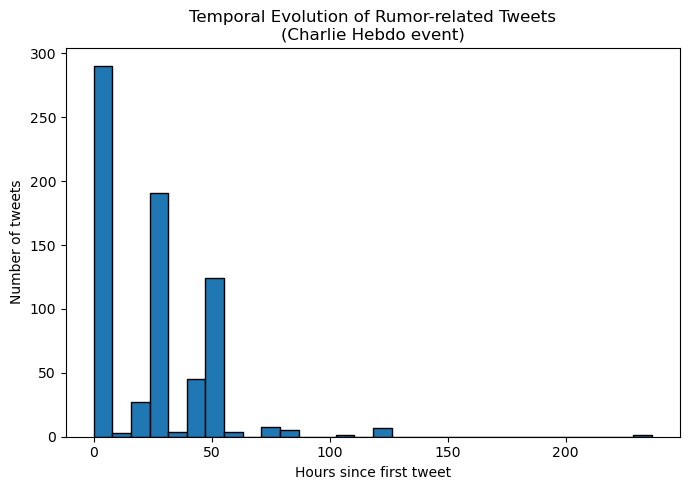

In [ ]:
times = [data.get("t") for _, data in H.nodes(data=True) if data.get("t") is not None]

if len(times) > 0:
    t0 = min(times)
    rel_hours = [(t - t0) / 3600.0 for t in times]  # 相对首条推的小时数

    plt.figure(figsize=(7,5))
    plt.hist(rel_hours, bins=30, edgecolor="black")
    plt.xlabel("Hours since first tweet")
    plt.ylabel("Number of tweets")
    plt.title("Temporal Evolution of Rumor-related Tweets\n(Charlie Hebdo event)")
    plt.tight_layout()
    plt.show()
else:
    print("No timestamp data found in H.")


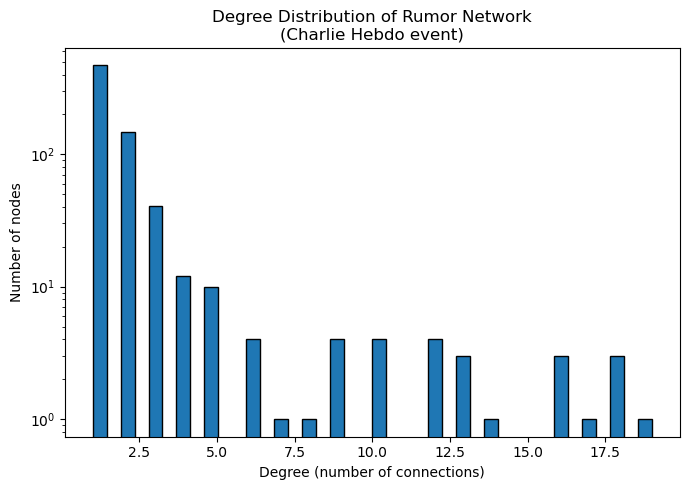

In [ ]:
degrees = [d for _, d in H.degree()]
plt.figure(figsize=(7,5))
plt.hist(degrees, bins=40, edgecolor="black")
plt.xlabel("Degree (number of connections)")
plt.ylabel("Number of nodes")
plt.yscale("log")
plt.title("Degree Distribution of Rumor Network\n(Charlie Hebdo event)")
plt.tight_layout()
plt.show()


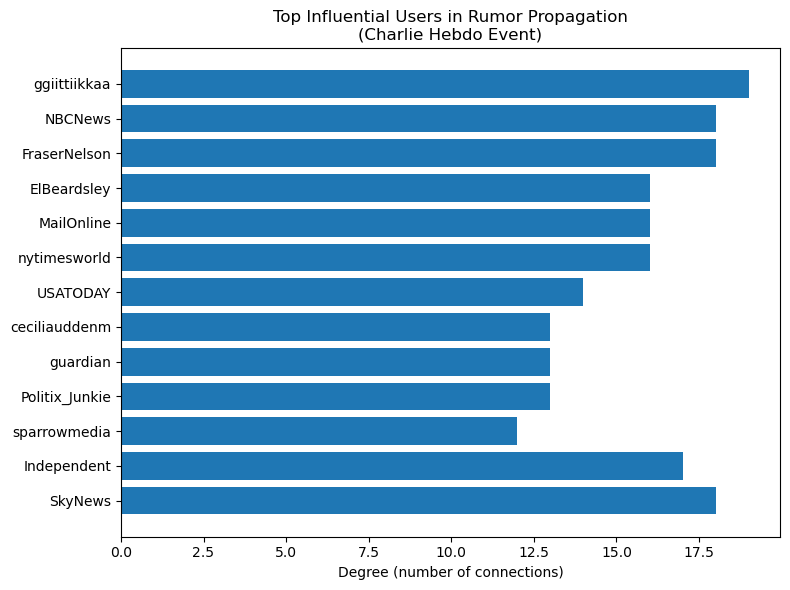

In [ ]:
import matplotlib.pyplot as plt

deg_c = dict(H.degree())
top_k = 15
top_nodes = sorted(deg_c.items(), key=lambda x: x[1], reverse=True)[:top_k]

names = []
values = []
for n, d in reversed(top_nodes):
    user = H.nodes[n].get("user") or str(n)[:8]
    names.append(user)
    values.append(d)

plt.figure(figsize=(8, 6))
plt.barh(names, values)
plt.xlabel("Degree (number of connections)")
plt.title("Top Influential Users in Rumor Propagation\n(Charlie Hebdo Event)")
plt.tight_layout()
plt.show()


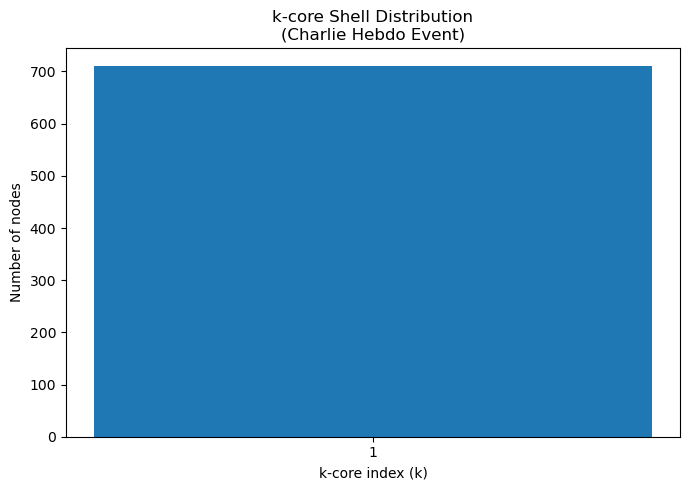

In [ ]:
import matplotlib.pyplot as plt
import collections
import networkx as nx

core_num = nx.core_number(H)
counter = collections.Counter(core_num.values())

ks = sorted(counter.keys())
counts = [counter[k] for k in ks]

plt.figure(figsize=(7,5))
plt.bar(ks, counts)
plt.xlabel("k-core index (k)")
plt.ylabel("Number of nodes")
plt.title("k-core Shell Distribution\n(Charlie Hebdo Event)")
plt.xticks(ks)
plt.tight_layout()
plt.show()


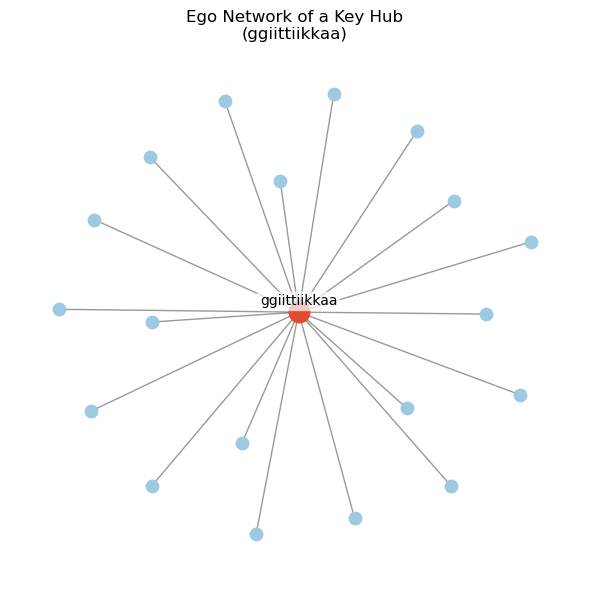

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

hub = max(H.degree(), key=lambda x: x[1])[0]
hub_name = H.nodes[hub].get("user") or str(hub)[:8]

ego = nx.ego_graph(H, hub, radius=1)

pos = nx.spring_layout(ego, seed=42)
plt.figure(figsize=(6,6))

neighbors = list(ego.nodes())
neighbors.remove(hub)

nx.draw_networkx_nodes(ego, pos, nodelist=neighbors, node_size=80, node_color="#9ecae1")
nx.draw_networkx_nodes(ego, pos, nodelist=[hub], node_size=220, node_color="#e34a33")
nx.draw_networkx_edges(ego, pos, alpha=0.4)

plt.text(pos[hub][0], pos[hub][1] + 0.03, hub_name,
         ha="center", fontsize=10, bbox=dict(boxstyle="round,pad=0.2",
                                             fc="white", ec="none", alpha=0.7))

plt.title(f"Ego Network of a Key Hub\n({hub_name})")
plt.axis("off")
plt.tight_layout()
plt.show()
